In [71]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [72]:
import numpy as np
import pandas as pd

In [73]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [74]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import create_engine, inspect

In [75]:
database_path = "/Users/kurtshiple/Desktop/catchup/resources/hawaii.sqlite"
engine = create_engine(f"sqlite:///{database_path}")

In [76]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [77]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [78]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [79]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [80]:
inspector = inspect(engine)

In [81]:
inspector.get_table_names()

['measurement', 'station']

In [14]:
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [15]:
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

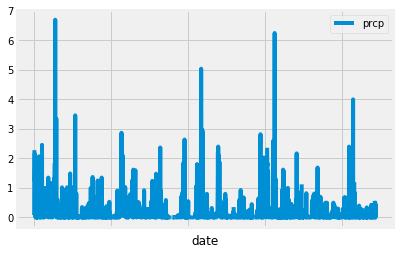

In [65]:
%matplotlib inline
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Latest Date
session.query(Measurement.date).order_by(Measurement.date.desc()).first()
session.query(Measurement.date).\
    filter(Measurement.date > '2016-08-23').\
    order_by(Measurement.date).all()
# Calculate the date 1 year ago from the last data point in the database
session.query(Measurement.date).\
    filter(Measurement.date == '2016-08-23').\
    order_by(Measurement.date).first()
# Perform a query to retrieve the data and precipitation scores
results =  session.query(Measurement.date,Measurement.prcp).\
    filter(Measurement.date > '2016-08-23').\
    order_by(Measurement.date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results[:], columns=['date', 'prcp'])
#df.dropna()

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(x="date",y="prcp")

![precipitation](Images/precipitation.png)

In [66]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [119]:
# Design a query to show how many stations are available in this dataset?
results1 = session.query(Measurement.station,Measurement.id).order_by(Measurement.station.asc()).all()
results1

[('USC00511918', 14960),
 ('USC00511918', 14961),
 ('USC00511918', 14962),
 ('USC00511918', 14963),
 ('USC00511918', 14964),
 ('USC00511918', 14965),
 ('USC00511918', 14966),
 ('USC00511918', 14967),
 ('USC00511918', 14968),
 ('USC00511918', 14969),
 ('USC00511918', 14970),
 ('USC00511918', 14971),
 ('USC00511918', 14972),
 ('USC00511918', 14973),
 ('USC00511918', 14974),
 ('USC00511918', 14975),
 ('USC00511918', 14976),
 ('USC00511918', 14977),
 ('USC00511918', 14978),
 ('USC00511918', 14979),
 ('USC00511918', 14980),
 ('USC00511918', 14981),
 ('USC00511918', 14982),
 ('USC00511918', 14983),
 ('USC00511918', 14984),
 ('USC00511918', 14985),
 ('USC00511918', 14986),
 ('USC00511918', 14987),
 ('USC00511918', 14988),
 ('USC00511918', 14989),
 ('USC00511918', 14990),
 ('USC00511918', 14991),
 ('USC00511918', 14992),
 ('USC00511918', 14993),
 ('USC00511918', 14994),
 ('USC00511918', 14995),
 ('USC00511918', 14996),
 ('USC00511918', 14997),
 ('USC00511918', 14998),
 ('USC00511918', 14999),


In [118]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
df1 = pd.DataFrame(results1)
df1 = df1.groupby("station").id.count()
df1 = pd.DataFrame(df1)
df1 = df1.sort_values(by=['id'], ascending=False)
df1.columns = ['count']
df1

,count
station,
USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


In [140]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

results2 = session.query(Measurement.station,Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    order_by(Measurement.tobs).all()
lowtemp = results2[0]
hightemp = results2[-1]
temps = [result[1] for result in results2]


total = 0
ticker = 0
for item in temps:
    total += item
    ticker += 1
avgtemp = total/ticker
[lowtemp[1], hightemp[1],avgtemp]

[54.0, 85.0, 71.66378066378067]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11b78a198>]],
      dtype=object)

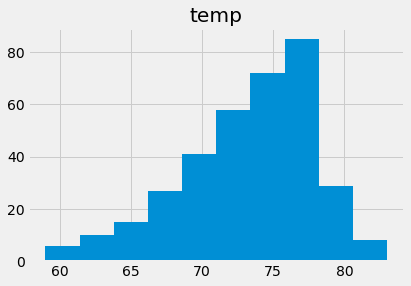

In [170]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
data = session.query(Measurement.tobs, Measurement.date, Measurement.station).\
filter(Measurement.station == 'USC00519281').\
filter(Measurement.date > '2016-08-23').\
order_by(Measurement.date).all()

data = pd.DataFrame(data)
data.columns = ['temp','date','station']
data.hist()


![precipitation](Images/station-histogram.png)

In [162]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [168]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

print(calc_temps('2016-08-23','2017-08-23'))

[(58.0, 74.59058295964125, 87.0)]


TypeError: bar() missing 1 required positional argument: 'height'

<IPython.core.display.Javascript object>


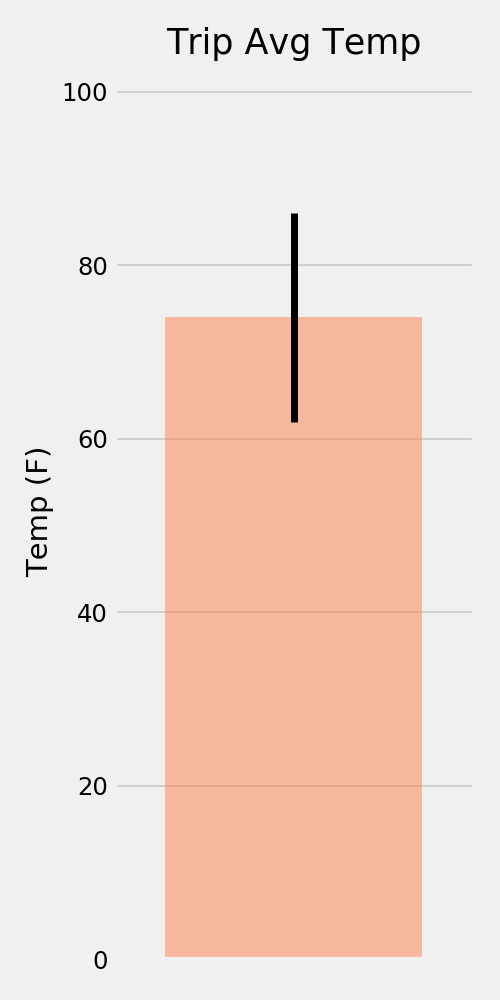

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


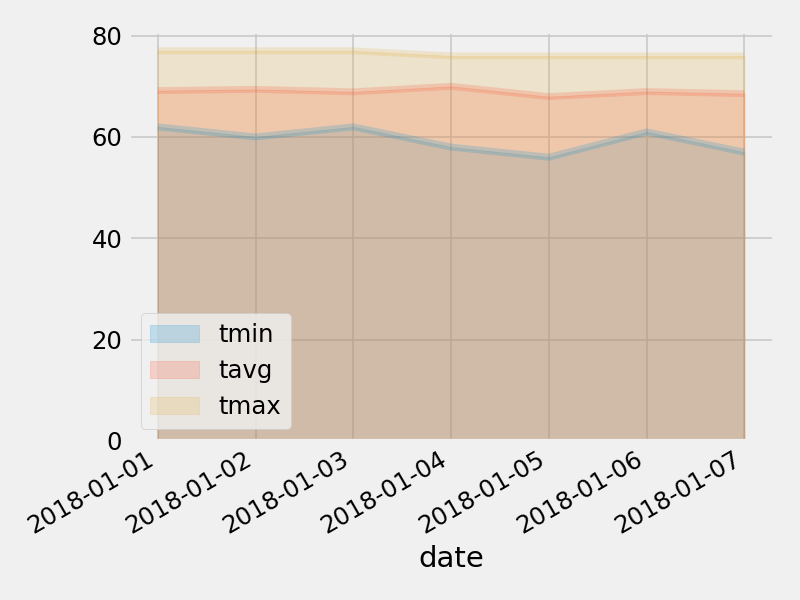

In [23]:
# Plot the daily normals as an area plot with `stacked=False`


In [179]:
dateprcp = session.query(Measurement.date, Measurement.prcp).all()

In [181]:
dict((y, x) for y, x in dateprcp)

{'2010-01-01': 0.14,
 '2010-01-02': 0.0,
 '2010-01-03': 0.0,
 '2010-01-04': 0.0,
 '2010-01-06': 0.36,
 '2010-01-07': 0.3,
 '2010-01-08': 0.0,
 '2010-01-09': 0.0,
 '2010-01-10': 0.01,
 '2010-01-11': 0.14,
 '2010-01-12': 0.0,
 '2010-01-14': 0.0,
 '2010-01-15': 0.0,
 '2010-01-16': 0.0,
 '2010-01-17': 0.0,
 '2010-01-18': 0.0,
 '2010-01-19': 0.0,
 '2010-01-20': 0.0,
 '2010-01-21': 0.32,
 '2010-01-22': 0.0,
 '2010-01-23': 0.0,
 '2010-01-24': 0.01,
 '2010-01-25': 0.0,
 '2010-01-26': 0.03,
 '2010-01-27': 0.31,
 '2010-01-28': 0.07,
 '2010-01-30': 0.33,
 '2010-01-31': 1.1,
 '2010-02-01': 0.01,
 '2010-02-03': 0.67,
 '2010-02-04': 0.0,
 '2010-02-05': 0.09,
 '2010-02-06': 0.04,
 '2010-02-07': 0.0,
 '2010-02-08': 0.0,
 '2010-02-09': 0.0,
 '2010-02-11': 0.0,
 '2010-02-12': 0.65,
 '2010-02-13': 0.62,
 '2010-02-14': 0.02,
 '2010-02-15': 0.0,
 '2010-02-16': 0.0,
 '2010-02-17': 0.02,
 '2010-02-19': 0.42,
 '2010-02-20': 0.55,
 '2010-02-21': 0.0,
 '2010-02-22': None,
 '2010-02-23': 0.0,
 '2010-02-24': 0.0,

In [183]:
session.query(Station.station).group_by(Station.station)